# 01 — EDA des Données du Système de Recommandation

Ce notebook réalise une analyse exploratoire complète des données d'interactions et des items pour le projet de recommandation.

Objectifs :
- Vérifier la qualité des données (types, valeurs manquantes, doublons).
- Comprendre la structure (nombre d'utilisateurs, d'items, de lignes).
- Analyser la distribution des interactions par utilisateur et par item (long-tail, popularité).
- Étudier la dimension temporelle et la récence.
- Examiner les métadonnées `items` (si disponibles) et la couverture `interactions` ↔ `items`.
- Calculer des métriques clés utiles pour la modélisation (densité, cold-start, etc.).


In [2]:
# Imports et configuration
import os
import math
import json
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


## 1) Chargement des données
Les chemins supposés sont `../data/interactions_train.csv` et `../data/items.csv`. Adaptez si besoin.


In [3]:
# Paramètres de chemin
DATA_DIR = os.path.join('..', 'data')
PATH_INTERACTIONS = os.path.join(DATA_DIR, 'interactions_train.csv')
PATH_ITEMS = os.path.join(DATA_DIR, 'items.csv')


def load_csv_safe(path, **kwargs):
    if os.path.exists(path):
        try:
            return pd.read_csv(path, **kwargs)
        except Exception as e:
            print(f'Erreur lors de la lecture de {path}:', e)
            return None
    else:
        print(f'Fichier introuvable: {path}')
        return None


interactions = load_csv_safe(PATH_INTERACTIONS, low_memory=False)
items = load_csv_safe(PATH_ITEMS, low_memory=False)

print('Chemin interactions:', PATH_INTERACTIONS)
print('Chemin items       :', PATH_ITEMS)

# Aperçu rapide
if interactions is not None:
    display(interactions.head(3))
else:
    print('interactions = None')

if items is not None:
    display(items.head(3))
else:
    print('items = None')


Chemin interactions: ../data/interactions_train.csv
Chemin items       : ../data/items.csv


,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2


## 2) Aperçu général et qualité des données
Nous vérifions les dimensions, les types, les doublons et les valeurs manquantes.


In [4]:
def describe_df(df, name='df'):
    if df is None:
        print(f'{name} indisponible.')
        return
    print(f'— {name} —')
    print('shape:', df.shape)
    display(df.head())
    print('\nTypes:')
    display(df.dtypes)
    print('\nValeurs manquantes (top 20):')
    display(df.isna().sum().sort_values(ascending=False).head(20))
    print('\nNombre de doublons (lignes entières):', int(df.duplicated().sum()))


describe_df(interactions, 'interactions')
describe_df(items, 'items')


— interactions —
shape: (87047, 3)


,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09



Types:


u      int64
i      int64
t    float64
dtype: object


Valeurs manquantes (top 20):


u    0
i    0
t    0
dtype: int64


Nombre de doublons (lignes entières): 2
— items —
shape: (15291, 6)


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4



Types:


Title         object
Author        object
ISBN Valid    object
Publisher     object
Subjects      object
i              int64
dtype: object


Valeurs manquantes (top 20):


Author        2653
Subjects      2223
ISBN Valid     723
Publisher       25
Title            0
i                0
dtype: int64


Nombre de doublons (lignes entières): 0


## 3) Schéma attendu et normalisation minimale
Le pipeline s'attend généralement aux colonnes suivantes dans `interactions` :
- `u` (user id), `i` (item id), `t` (timestamp/ordonnancement temporel).

Cette section force des types cohérents si possible, sans modifier le fichier source.


In [5]:
# Casting doux des colonnes clés si présentes
if interactions is not None:
    for col in ['u', 'i']:
        if col in interactions.columns:
            try:
                interactions[col] = interactions[col].astype('Int64')
            except Exception as e:
                print(f'Impossible de caster {col} en entier:', e)

    # Gestion de la colonne temporelle `t`
    if 't' in interactions.columns:
        # Heuristique: si t est numérique et > 10^10 -> ms; > 10^12 -> µs
        t_series = interactions['t']
        if pd.api.types.is_numeric_dtype(t_series):
            t_max = t_series.max()
            if t_max > 1e12:
                interactions['_t_dt'] = pd.to_datetime(t_series, unit='us', errors='coerce')
            elif t_max > 1e10:
                interactions['_t_dt'] = pd.to_datetime(t_series, unit='ms', errors='coerce')
            else:
                interactions['_t_dt'] = pd.to_datetime(t_series, unit='s', errors='coerce')
        else:
            interactions['_t_dt'] = pd.to_datetime(t_series, errors='coerce', infer_datetime_format=True)
    else:
        interactions['_t_dt'] = pd.NaT

    # Détection des doublons
    interactions['_is_dup'] = interactions.duplicated()
    n_dups = int(interactions['_is_dup'].sum())
    print(f'Doublons détectés dans interactions: {n_dups}')

    # Statistiques clés
    n_rows = len(interactions)
    n_users = interactions['u'].nunique() if 'u' in interactions.columns else None
    n_items = interactions['i'].nunique() if 'i' in interactions.columns else None
    print({'n_rows': n_rows, 'n_users': n_users, 'n_items': n_items})


Doublons détectés dans interactions: 2
{'n_rows': 87047, 'n_users': 7838, 'n_items': 15109}


## 4) Distributions des interactions
Analyse des interactions par utilisateur et par item (long-tail).


— Stats interactions par utilisateur —


count       7838.0
mean     11.105767
std      16.441875
min            3.0
50%            6.0
75%           11.0
90%           24.0
95%           38.0
99%           84.0
max          385.0
Name: count, dtype: Float64

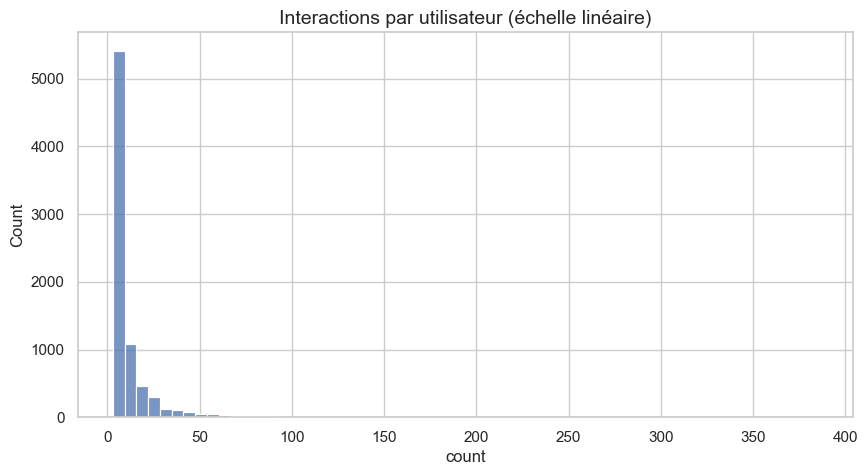

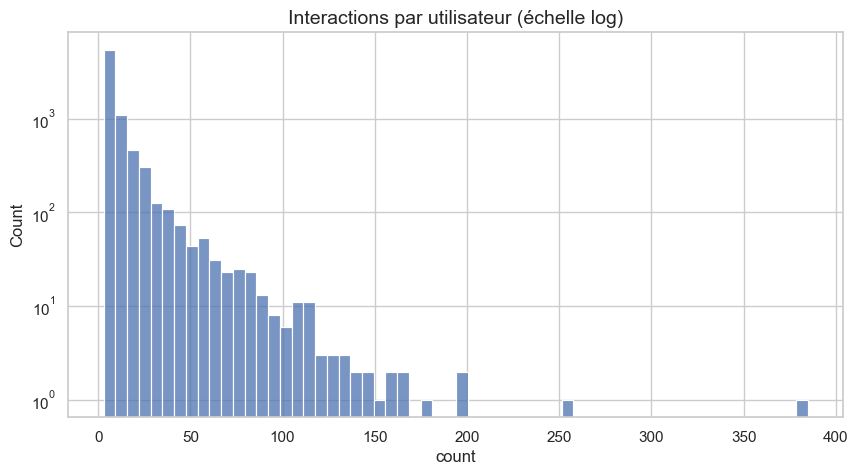

— Stats interactions par item —


count     15109.0
mean     5.761268
std      9.004874
min           1.0
50%           4.0
75%           6.0
90%           9.0
95%          12.0
99%          29.0
max         380.0
Name: count, dtype: Float64

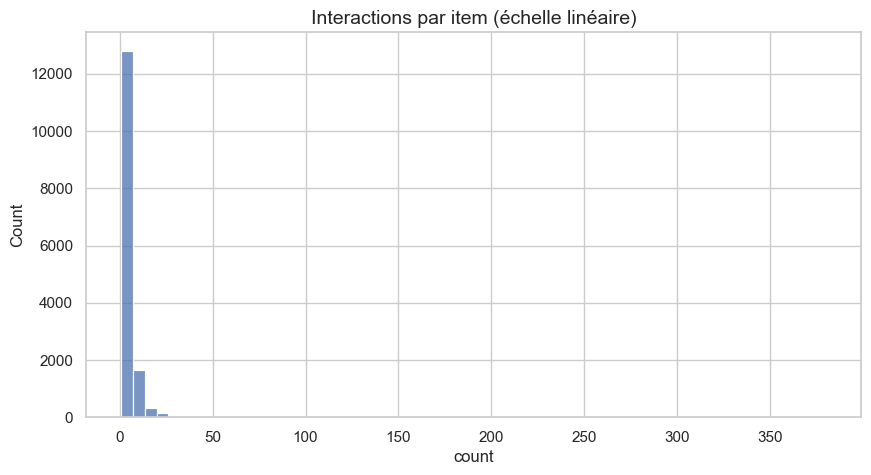

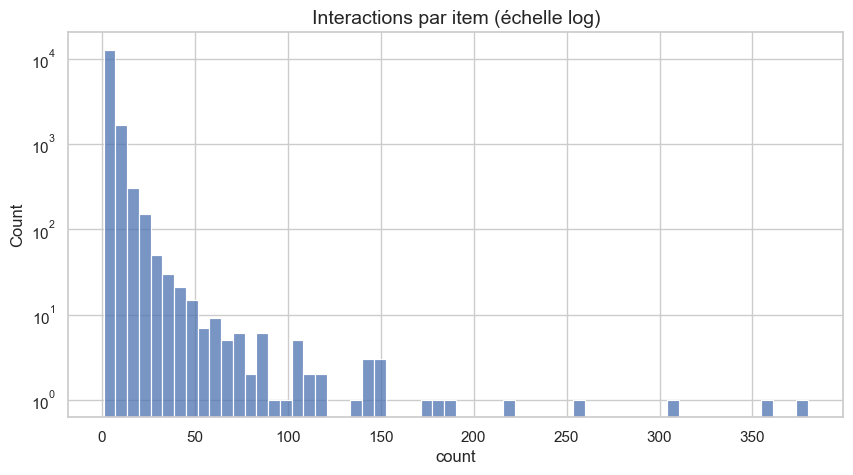

,user,count
0,6869,385
1,4473,254
2,1884,200
3,732,199
4,1744,175
5,1106,165
6,262,163
7,2648,162
8,7507,157
9,3274,152


,item,count
0,11366,380
1,3055,357
2,10715,305
3,8999,257
4,611,217
5,4426,189
6,53,178
7,2820,177
8,13885,151
9,14555,151


{'n_users': 7838, 'n_items': 15109, 'n_interactions': 87047, 'density': 0.0007350431383439732}


In [6]:
import matplotlib


def safe_hist(series, bins=50, title='', log=False):
    if series is None or len(series) == 0:
        print('Série vide')
        return
    data = pd.Series(series).dropna()
    ax = sns.histplot(data, bins=bins)
    if log:
        ax.set(yscale='log')
    ax.set_title(title)
    plt.show()


if interactions is not None and 'u' in interactions.columns and 'i' in interactions.columns:
    cnt_u = interactions['u'].value_counts()
    cnt_i = interactions['i'].value_counts()

    print('— Stats interactions par utilisateur —')
    display(cnt_u.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
    safe_hist(cnt_u, bins=60, title='Interactions par utilisateur (échelle linéaire)')
    safe_hist(cnt_u, bins=60, title='Interactions par utilisateur (échelle log)', log=True)

    print('— Stats interactions par item —')
    display(cnt_i.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
    safe_hist(cnt_i, bins=60, title='Interactions par item (échelle linéaire)')
    safe_hist(cnt_i, bins=60, title='Interactions par item (échelle log)', log=True)

    # Top entités
    display(pd.DataFrame({'user': cnt_u.head(10).index, 'count': cnt_u.head(10).values}))
    display(pd.DataFrame({'item': cnt_i.head(10).index, 'count': cnt_i.head(10).values}))

    # Densité/sparsité approximatives du graphe biparti
    n_users = interactions['u'].nunique()
    n_items = interactions['i'].nunique()
    n_edges = len(interactions)
    density = n_edges / (n_users * n_items) if n_users and n_items else np.nan
    print({'n_users': n_users, 'n_items': n_items, 'n_interactions': n_edges, 'density': float(density)})


## 5) Analyse temporelle
Conversion et agrégation du temps si `t` est disponible.


{'t_min': '2023-01-02 12:47:23', 't_max': '2024-10-14 16:57:34'}


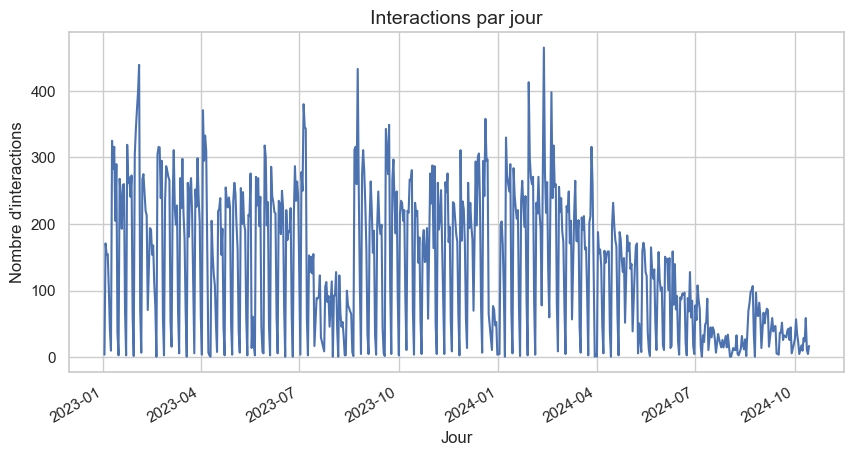

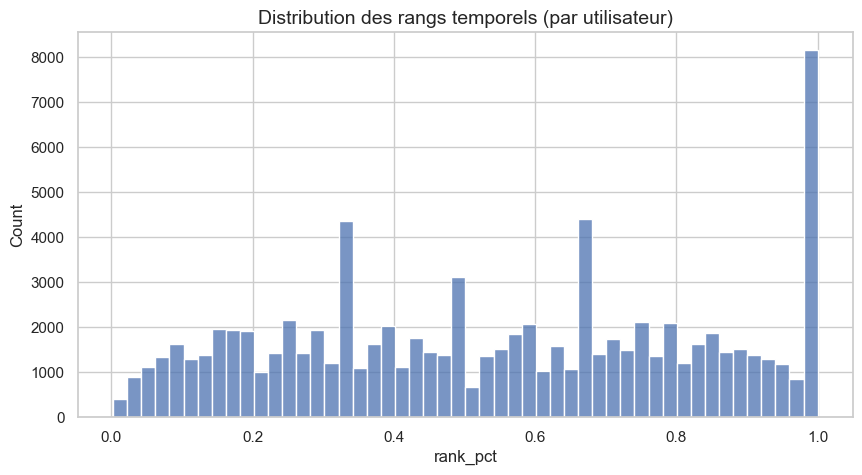

In [7]:
if interactions is not None and '_t_dt' in interactions.columns:
    # Couverture temporelle
    t_min = interactions['_t_dt'].min()
    t_max = interactions['_t_dt'].max()
    print({'t_min': str(t_min), 't_max': str(t_max)})

    # Interactions par jour
    by_day = interactions.dropna(subset=['_t_dt']).copy()
    if not by_day.empty:
        by_day['day'] = by_day['_t_dt'].dt.to_period('D').dt.to_timestamp()
        g = by_day.groupby('day').size()
        ax = g.plot(kind='line', title='Interactions par jour')
        ax.set_xlabel('Jour')
        ax.set_ylabel('Nombre d\'interactions')
        plt.show()

        # Récence par utilisateur (rang percentile temporel)
        tmp = by_day.copy()
        if 'u' in tmp.columns:
            tmp['rank_pct'] = tmp.groupby('u')['_t_dt'].rank(pct=True, method='first')
            safe_hist(tmp['rank_pct'], bins=50, title='Distribution des rangs temporels (par utilisateur)')
else:
    print('Colonne temporelle `_t_dt` indisponible.')


## 6) Long-tail et popularité cumulative
Part du volume d'interactions couverte par les items les plus populaires.


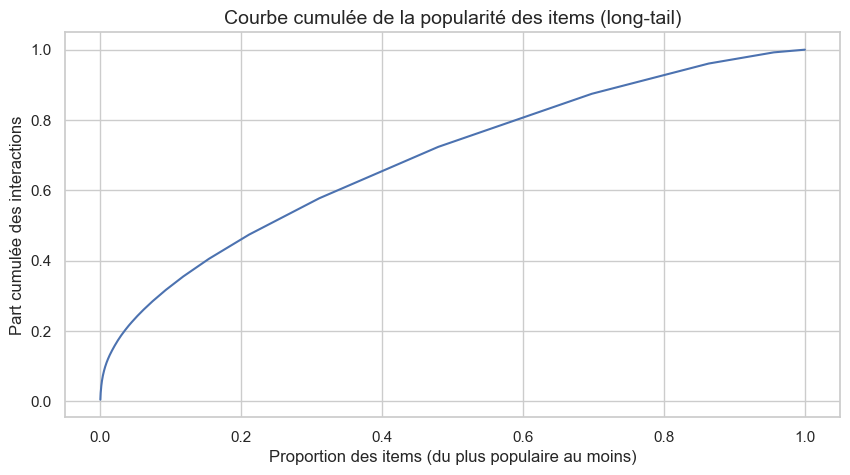

~1% des items les plus populaires couvrent ~11.6% des interactions
~5% des items les plus populaires couvrent ~23.7% des interactions
~10% des items les plus populaires couvrent ~32.7% des interactions
~20% des items les plus populaires couvrent ~46.1% des interactions


In [8]:
if interactions is not None and 'i' in interactions.columns:
    cnt_i = interactions['i'].value_counts()
    share = (cnt_i / cnt_i.sum()).sort_values(ascending=False).cumsum().reset_index(drop=True)
    x = np.arange(1, len(share) + 1) / len(share)
    plt.plot(x, share.values)
    plt.title('Courbe cumulée de la popularité des items (long-tail)')
    plt.xlabel('Proportion des items (du plus populaire au moins)')
    plt.ylabel('Part cumulée des interactions')
    plt.grid(True)
    plt.show()

    # Points de repère
    for p in [0.01, 0.05, 0.1, 0.2]:
        idx = int(len(share) * p) - 1
        if idx >= 0:
            print(f'~{int(p*100)}% des items les plus populaires couvrent ~{share.iloc[idx]*100:.1f}% des interactions')


## 7) Cold-start approximatif
Proportion d'utilisateurs/items avec peu d'interactions.


In [9]:
def ratio_leq(counts, k):
    if counts is None or len(counts) == 0:
        return np.nan
    return float((counts <= k).mean())


if interactions is not None and {'u', 'i'}.issubset(interactions.columns):
    cnt_u = interactions['u'].value_counts()
    cnt_i = interactions['i'].value_counts()
    for k in [1, 2, 3, 5, 10]:
        print({
            'k': k,
            'ratio_users_<=k': ratio_leq(cnt_u, k),
            'ratio_items_<=k': ratio_leq(cnt_i, k),
        })


{'k': 1, 'ratio_users_<=k': 0.0, 'ratio_items_<=k': 0.045800516248593555}
{'k': 2, 'ratio_users_<=k': 0.0, 'ratio_items_<=k': 0.13839433450261435}
{'k': 3, 'ratio_users_<=k': 0.31194182189334013, 'ratio_items_<=k': 0.30425574161096036}
{'k': 5, 'ratio_users_<=k': 0.47677979076294974, 'ratio_items_<=k': 0.6913760010589715}
{'k': 10, 'ratio_users_<=k': 0.717147231436591, 'ratio_items_<=k': 0.9282546826394864}


## 8) EDA des Items (si disponible)
Inspection des métadonnées d'items et couverture avec les interactions.


In [10]:
if items is not None:
    describe_df(items, 'items (détails)')
    # Couverture du mapping interactions->items
    if interactions is not None and 'i' in interactions.columns and 'i' in items.columns:
        inter_item_ids = set(interactions['i'].dropna().unique())
        item_ids = set(items['i'].dropna().unique())
        covered = len(inter_item_ids & item_ids) / max(len(inter_item_ids), 1)
        print({'items_couverts_par_metadata': covered})
        # Jointure pour trouver les interactions sans métadonnées
        miss_meta = interactions[~interactions['i'].isin(items['i'])] if not items.empty else interactions
        print('Interactions sans métadonnées items:', len(miss_meta))
    # Aperçu de colonnes catégorielles usuelles si présentes
    for col in ['category', 'genre', 'tags', 'language']:
        if col in items.columns:
            print(f'— Distribution de {col} —')
            display(items[col].value_counts().head(20))


— items (détails) —
shape: (15291, 6)


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4



Types:


Title         object
Author        object
ISBN Valid    object
Publisher     object
Subjects      object
i              int64
dtype: object


Valeurs manquantes (top 20):


Author        2653
Subjects      2223
ISBN Valid     723
Publisher       25
Title            0
i                0
dtype: int64


Nombre de doublons (lignes entières): 0
{'items_couverts_par_metadata': 1.0}
Interactions sans métadonnées items: 0


## 9) Visualisation de la matrice utilisateur-item (échantillon)
Illustration de la sparsité sur un sous-échantillon.


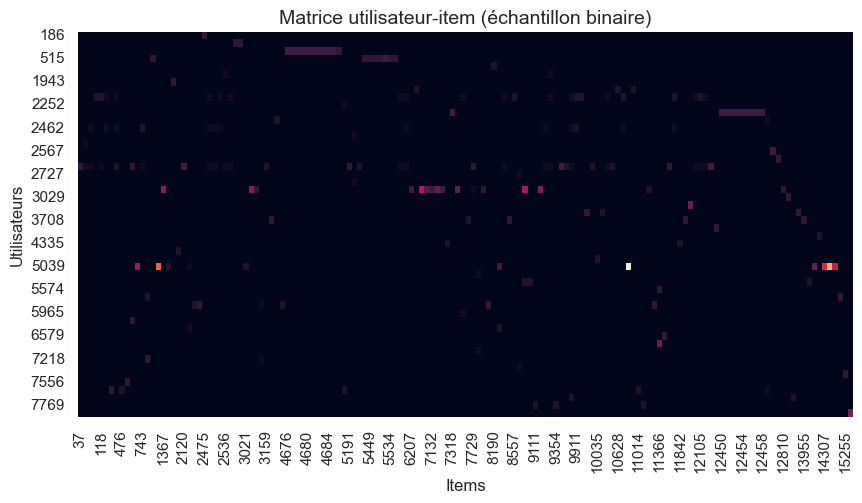

In [11]:
if interactions is not None and {'u', 'i'}.issubset(interactions.columns):
    # Échantillonner un petit sous-ensemble
    rng = np.random.default_rng(42)
    n_unique_u = interactions['u'].nunique()
    n_sample = int(min(100, max(1, n_unique_u)))
    sample_users = pd.Series(interactions['u'].dropna().unique())
    if len(sample_users) > n_sample:
        sample_users = sample_users.sample(n=n_sample, random_state=42)
    sub = interactions[interactions['u'].isin(sample_users)].copy()
    top_items = sub['i'].value_counts().head(150).index
    sub = sub[sub['i'].isin(top_items)]
    try:
        mat = sub.assign(val=1).pivot_table(index='u', columns='i', values='val', aggfunc='size', fill_value=0)
        sns.heatmap(mat, cbar=False)
        plt.title('Matrice utilisateur-item (échantillon binaire)')
        plt.xlabel('Items')
        plt.ylabel('Utilisateurs')
        plt.show()
    except Exception as e:
        print('Impossible de créer la heatmap:', e)


## 10) Résumé exécutif des métriques clés
Résumé rapide pour guider la modélisation.


In [12]:
summary = {}
if interactions is not None:
    summary['n_rows_interactions'] = int(len(interactions))
    summary['n_users'] = int(interactions['u'].nunique()) if 'u' in interactions.columns else None
    summary['n_items'] = int(interactions['i'].nunique()) if 'i' in interactions.columns else None
    if {'u', 'i'}.issubset(interactions.columns) and interactions['u'].nunique() and interactions['i'].nunique():
        density = len(interactions) / (interactions['u'].nunique() * interactions['i'].nunique())
        summary['density'] = float(density)
    if '_t_dt' in interactions.columns:
        summary['t_min'] = str(pd.to_datetime(interactions['_t_dt'].min()))
        summary['t_max'] = str(pd.to_datetime(interactions['_t_dt'].max()))

if items is not None:
    summary['n_rows_items'] = int(len(items))
    if 'i' in items.columns:
        summary['n_items_in_items'] = int(items['i'].nunique())

print(json.dumps(summary, indent=2, ensure_ascii=False))


{
  "n_rows_interactions": 87047,
  "n_users": 7838,
  "n_items": 15109,
  "density": 0.0007350431383439732,
  "t_min": "2023-01-02 12:47:23",
  "t_max": "2024-10-14 16:57:34",
  "n_rows_items": 15291,
  "n_items_in_items": 15291
}


## 10) Bins d'interactions par utilisateur — pourcentages et CDF
Calcul des pourcentages d'utilisateurs ayant un nombre d'interactions compris entre des bornes [x, y].


Pourcentage des utilisateurs par tranche d'interactions (%)


count
1          0.00
2          0.00
3-5       47.68
6-10      24.04
11-20     15.62
21-50      9.49
51-100     2.55
100+       0.63
Name: proportion, dtype: float64

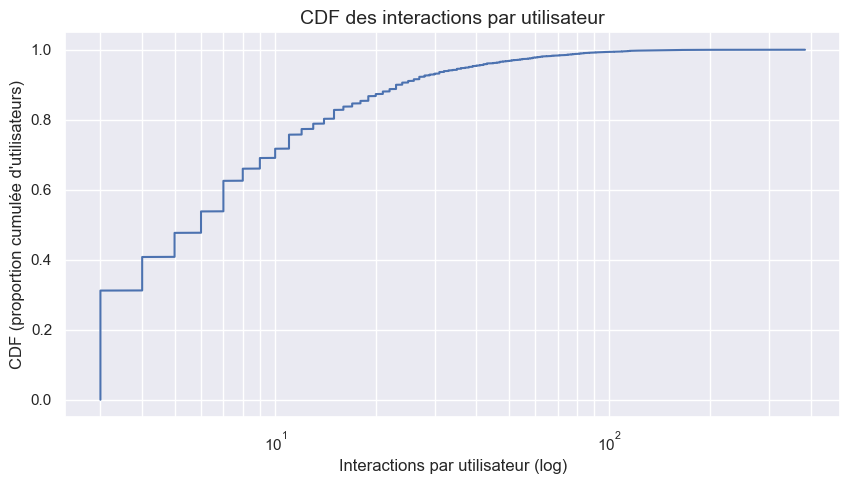

In [13]:
if interactions is not None and 'u' in interactions.columns:
    cnt_u = interactions['u'].value_counts().sort_values()
    # Définir des bins pertinents (modifiable)
    bins = [0, 1, 2, 5, 10, 20, 50, 100, np.inf]
    labels = [
        '1', '2', '3-5', '6-10', '11-20', '21-50', '51-100', '100+'
    ]
    # Adapter labels à bins
    if len(labels) != len(bins) - 1:
        labels = [f"({int(bins[i])+1}–{int(bins[i+1])})" for i in range(len(bins)-1)]
    binned = pd.cut(cnt_u, bins=bins, labels=labels, right=True, include_lowest=True)
    dist = binned.value_counts(normalize=True).sort_index() * 100
    print('Pourcentage des utilisateurs par tranche d\'interactions (%)')
    display(dist.round(2))

    # CDF
    cdf = (np.arange(1, len(cnt_u)+1) / len(cnt_u))
    cnt_sorted = cnt_u.values
    df_cdf = pd.DataFrame({'interactions': cnt_sorted, 'cdf_users': cdf})
    plt.plot(df_cdf['interactions'], df_cdf['cdf_users'])
    plt.xscale('log')
    plt.xlabel('Interactions par utilisateur (log)')
    plt.ylabel('CDF (proportion cumulée d\'utilisateurs)')
    plt.title('CDF des interactions par utilisateur')
    plt.grid(True, which='both', axis='both')
    plt.show()
else:
    print('interactions ou colonne u manquante')


## 11) Saisonnalité — Quand a-t-on le plus d'interactions ?
Par mois, jour de la semaine, et heure (si horodatage disponible).


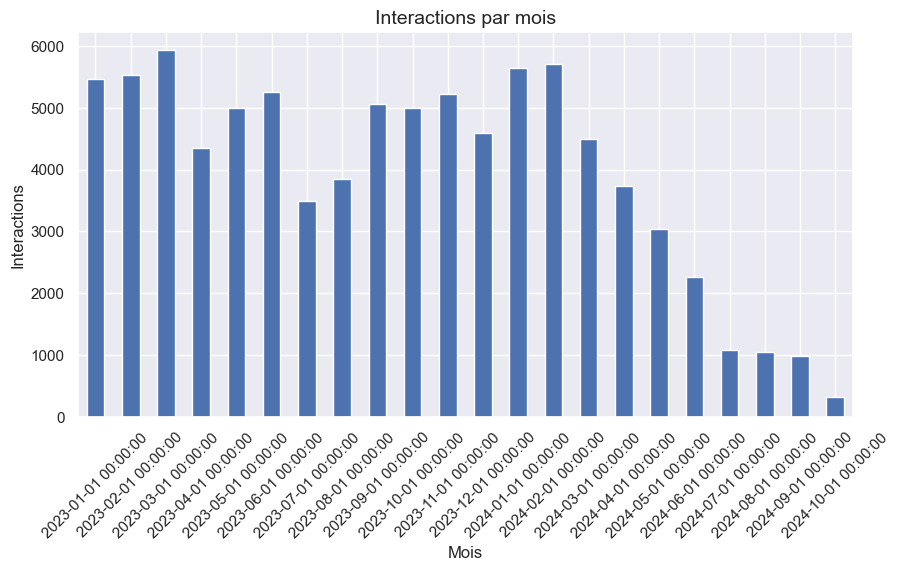

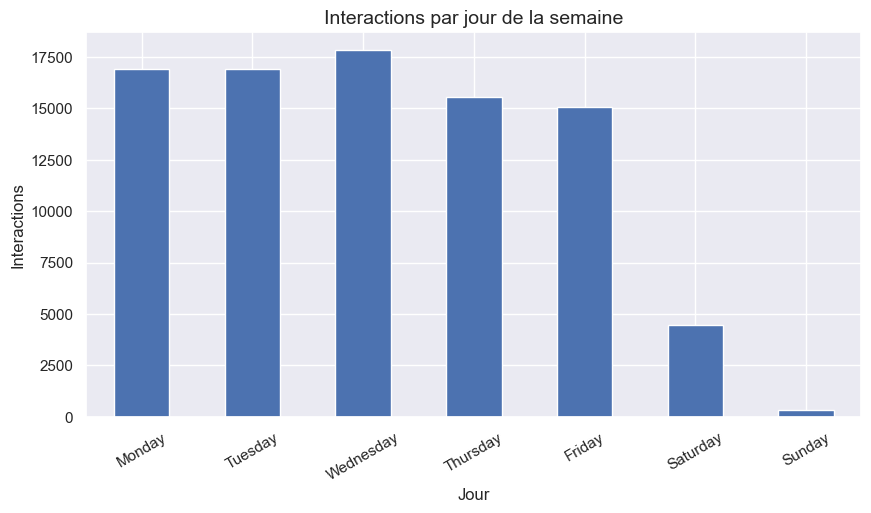

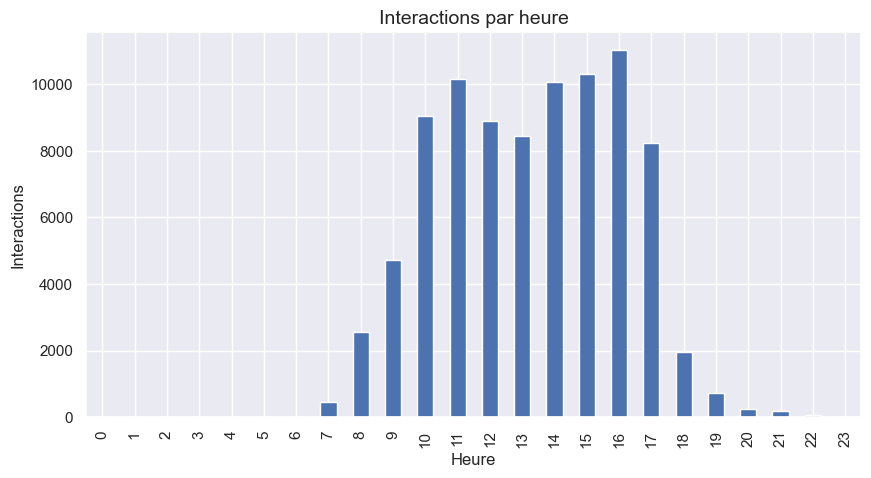

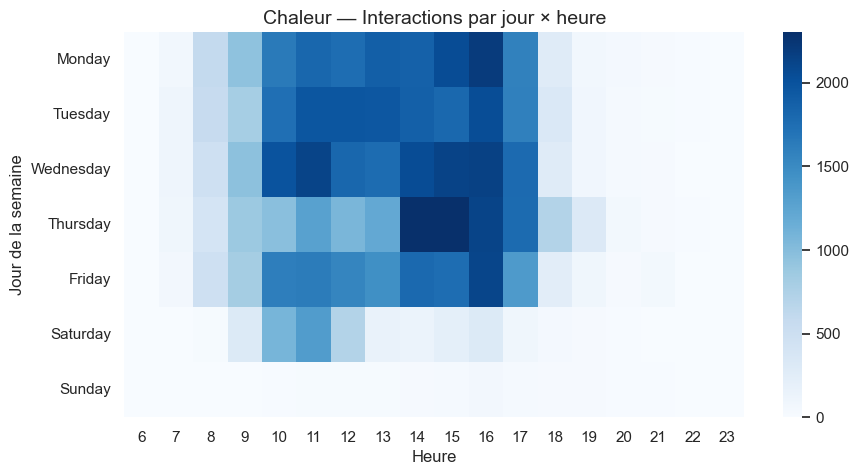

Pic par mois (Top 3):


month
2023-03-01    5927
2024-02-01    5699
2024-01-01    5642
dtype: int64

Pic par jour (Top 3):


dow
Wednesday    17815
Tuesday      16923
Monday       16879
dtype: int64

Pic par heure (Top 3):


hour
16    11014
15    10305
11    10164
dtype: int64

In [17]:
if interactions is not None and '_t_dt' in interactions.columns and interactions['_t_dt'].notna().any():
    tmp = interactions.dropna(subset=['_t_dt']).copy()
    tmp['month'] = tmp['_t_dt'].dt.to_period('M').dt.to_timestamp()
    tmp['dow'] = tmp['_t_dt'].dt.day_name()
    tmp['hour'] = tmp['_t_dt'].dt.hour

    # Par mois
    by_month = tmp.groupby('month').size()
    ax = by_month.plot(kind='bar', title='Interactions par mois')
    ax.set_xlabel('Mois'); ax.set_ylabel('Interactions')
    plt.xticks(rotation=45)
    plt.show()

    # Jour de la semaine
    dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    by_dow = tmp.groupby('dow').size().reindex(dow_order)
    ax = by_dow.plot(kind='bar', title='Interactions par jour de la semaine')
    ax.set_xlabel('Jour'); ax.set_ylabel('Interactions')
    plt.xticks(rotation=30)
    plt.show()

    # Par heure
    by_hour = tmp.groupby('hour').size().reindex(range(24), fill_value=0)
    ax = by_hour.plot(kind='bar', title='Interactions par heure')
    ax.set_xlabel('Heure'); ax.set_ylabel('Interactions')
    plt.show()

    # Heatmap dow x hour
    """pivot = tmp.pivot_table(index=tmp['_t_dt'].dt.day_name(), columns=tmp['_t_dt'].dt.hour, values='u', aggfunc='count').reindex(dow_order)
    sns.heatmap(pivot.fillna(0), cmap='Blues')"""

    pivot = tmp.pivot_table(
    index=tmp['_t_dt'].dt.day_name(),
    columns=tmp['_t_dt'].dt.hour,
    values='u',
    aggfunc='count').reindex(dow_order)

    pivot = pivot.fillna(0).astype(int)   # 👈 conversion sûre
    sns.heatmap(pivot, cmap='Blues')

    plt.title('Chaleur — Interactions par jour × heure')
    plt.xlabel('Heure'); plt.ylabel('Jour de la semaine')
    plt.show()

    # Pics
    top_month = by_month.sort_values(ascending=False).head(3)
    top_dow = by_dow.sort_values(ascending=False).head(3)
    top_hour = by_hour.sort_values(ascending=False).head(3)
    print('Pic par mois (Top 3):'); display(top_month)
    print('Pic par jour (Top 3):'); display(top_dow)
    print('Pic par heure (Top 3):'); display(top_hour)
else:
    print('Horodatage indisponible pour la saisonnalité.')


## 12) Ré-achat (re-buy) — répétitions user×item
Un ré-achat est défini comme un même utilisateur interagissant plusieurs fois avec le même item.


{'rebuy_rate_pairs_%': 16.21, 'rebuy_share_of_interactions_%': np.float64(26.47)}


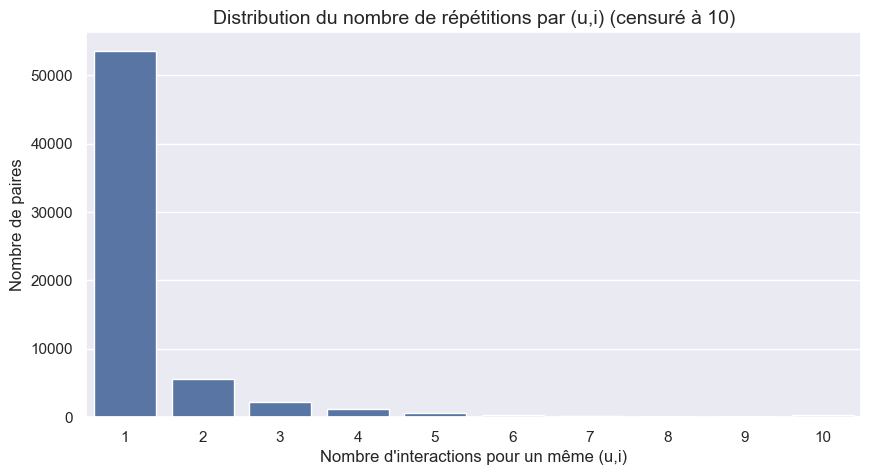

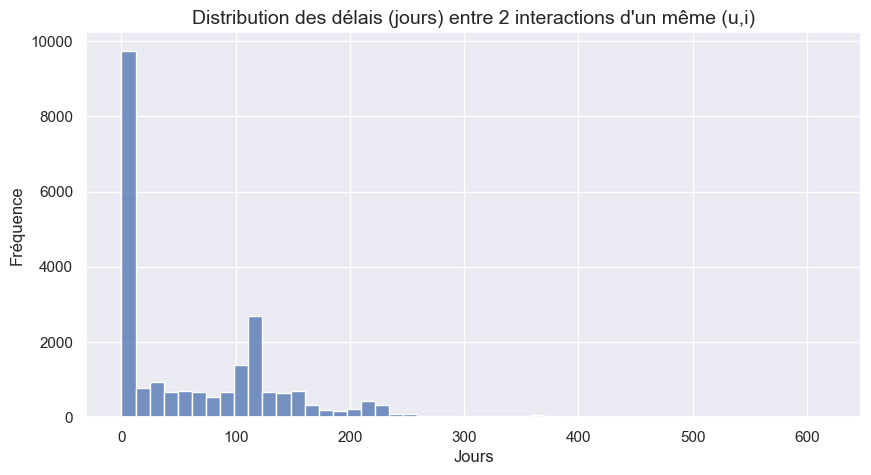

In [18]:
if interactions is not None and {'u','i'}.issubset(interactions.columns):
    pair_counts = interactions.groupby(['u','i']).size().rename('n').reset_index()
    repeats = pair_counts[pair_counts['n'] > 1]
    rebuy_rate_pairs = 100.0 * len(repeats) / max(len(pair_counts), 1)
    # Part des interactions totales qui sont des répétitions (au-delà de la 1ère)
    total_inter = len(interactions)
    repeated_interactions = (pair_counts['n'] - 1).clip(lower=0).sum()
    rebuy_share_interactions = 100.0 * repeated_interactions / max(total_inter, 1)

    print({'rebuy_rate_pairs_%': round(rebuy_rate_pairs,2), 'rebuy_share_of_interactions_%': round(rebuy_share_interactions,2)})
    # Distribution des répétitions
    sns.countplot(x='n', data=pair_counts.clip(upper=10))
    plt.title('Distribution du nombre de répétitions par (u,i) (censuré à 10)')
    plt.xlabel('Nombre d\'interactions pour un même (u,i)'); plt.ylabel('Nombre de paires')
    plt.show()

    # Temps entre répétitions (si t disponible)
    if '_t_dt' in interactions.columns and interactions['_t_dt'].notna().any():
        diffs = []
        for (u,i), g in interactions.dropna(subset=['_t_dt']).sort_values(['u','i','_t_dt']).groupby(['u','i']):
            dt = g['_t_dt'].diff().dropna().dt.total_seconds() / (3600*24)
            diffs.extend(dt.values.tolist())
        if len(diffs) > 0:
            sns.histplot(pd.Series(diffs), bins=50)
            plt.title('Distribution des délais (jours) entre 2 interactions d\'un même (u,i)')
            plt.xlabel('Jours'); plt.ylabel('Fréquence')
            plt.show()
        else:
            print('Pas assez de données temporelles pour les délais de re-buy.')
else:
    print('Colonnes u/i manquantes pour l\'analyse re-buy.')


## 13) Items populaires et couverture
Top items et part de couverture des interactions par Top-N.


In [19]:
if interactions is not None and 'i' in interactions.columns:
    cnt_i = interactions['i'].value_counts()
    print('Top 20 items populaires:')
    display(cnt_i.head(20))

    total = cnt_i.sum()
    for N in [10, 50, 100, 500, 1000]:
        if N <= len(cnt_i):
            shareN = 100.0 * cnt_i.head(N).sum() / total
            print(f'Part des interactions couvertes par Top-{N}: {shareN:.2f}%')
else:
    print('interactions ou colonne i manquante')


Top 20 items populaires:


i
11366    380
3055     357
10715    305
8999     257
611      217
4426     189
53       178
2820     177
13885    151
14555    151
14163    148
14578    145
13587    143
2741     141
12850    136
1351     118
2614     117
2742     111
8474     111
740      107
Name: count, dtype: Int64

Part des interactions couvertes par Top-10: 2.71%
Part des interactions couvertes par Top-50: 6.92%
Part des interactions couvertes par Top-100: 9.62%
Part des interactions couvertes par Top-500: 19.66%
Part des interactions couvertes par Top-1000: 26.95%


## 14) `sample_submission` — Couverture Warm vs Cold
Compare les `user_id` demandés par la soumission avec les utilisateurs vus au train.


In [21]:
PATH_SAMPLE_SUB = os.path.join(DATA_DIR, 'sample_submission.csv')
if os.path.exists(PATH_SAMPLE_SUB):
    sample_submission = load_csv_safe(PATH_SAMPLE_SUB)
    if sample_submission is not None and 'user_id' in sample_submission.columns and interactions is not None and 'u' in interactions.columns:
        target_users = set(sample_submission['user_id'].unique())
        train_users = set(interactions['u'].dropna().unique())
        warm = target_users & train_users
        cold = target_users - train_users
        print({
            'n_target_users': len(target_users),
            'warm_users': len(warm),
            'cold_users': len(cold),
            'warm_%': round(100.0 * len(warm) / max(len(target_users),1), 2),
            'cold_%': round(100.0 * len(cold) / max(len(target_users),1), 2),
        })
        print('Exemples d\'utilisateurs cold-start (jusqu\'à 10):', list(sorted(cold))[:10])
    else:
        print('Colonnes ou données manquantes pour l\'analyse de couverture.')
else:
    print('sample_submission.csv introuvable — section ignorée.')


{'n_target_users': 7838, 'warm_users': 7838, 'cold_users': 0, 'warm_%': 100.0, 'cold_%': 0.0}
Exemples d'utilisateurs cold-start (jusqu'à 10): []


## 15) Export des artefacts EDA
Sauvegarde des principaux tableaux/résumés sous `data/eda/` pour réutilisation.


In [22]:
EDA_DIR = os.path.join(DATA_DIR, 'eda')
try:
    os.makedirs(EDA_DIR, exist_ok=True)
    if interactions is not None and 'u' in interactions.columns:
        cnt_u = interactions['u'].value_counts().rename('count').reset_index().rename(columns={'index':'u'})
        cnt_u.to_csv(os.path.join(EDA_DIR, 'user_interaction_counts.csv'), index=False)
    if interactions is not None and 'i' in interactions.columns:
        cnt_i = interactions['i'].value_counts().rename('count').reset_index().rename(columns={'index':'i'})
        cnt_i.to_csv(os.path.join(EDA_DIR, 'item_popularity_counts.csv'), index=False)
    if interactions is not None and '_t_dt' in interactions.columns and interactions['_t_dt'].notna().any():
        tmp = interactions.dropna(subset=['_t_dt']).copy()
        by_day = tmp.groupby(tmp['_t_dt'].dt.to_period('D').dt.to_timestamp()).size().rename('count').reset_index(name='count')
        if isinstance(by_day, pd.Series):
            by_day = by_day.reset_index()
        by_day.to_csv(os.path.join(EDA_DIR, 'interactions_by_day.csv'), index=False)
    print(f"Artefacts EDA sauvegardés dans {EDA_DIR}")
except Exception as e:
    print(f"Échec de sauvegarde des artefacts EDA: {e}")


Artefacts EDA sauvegardés dans ../data/eda
